# Numeric Inverse Kinematics

In [1]:
import numpy as np

In [54]:
def get_angles(x, y, z, phi3, theta3, r1=1, r2=1, r3=1):
    phi1 = np.arctan2(-r3*np.sin(phi3)*np.sin(theta3)+y, -r3*np.sin(theta3)*np.cos(phi3)+x)
    
    # 
    a3 = np.array([r3*np.sin(theta3)*np.cos(phi3),
                   r3*np.sin(theta3)*np.sin(phi3),
                   r3*np.cos(theta3)])
    x3 = np.array([x, y, z])
    x2 = x3 - a3
    
    x2d = np.sqrt(x2[0]**2 + x2[1]**2 + x2[2]**2)
    p2d = np.sqrt(x2[0]**2 + x2[1]**2)
    
    theta1 = np.pi/2 - np.arccos(p2d/x2d) - np.arccos((x2d**2 + r1**2 - r2**2) / (2*x2d*r1))
    dtheta2 = np.pi - np.arccos((r1**2+r2**2-x2d**2)/(2*r1*r2))
    theta2 = theta1 + dtheta2
    

    px = r3*(-np.sin(theta2)*np.cos(theta3) + np.sin(theta3)*np.cos(theta2)*np.cos(phi1-phi3))
    py = -r3*np.sin(theta3)*np.sin(phi1-phi3)
    pz = r3* (np.sin(theta2)*np.sin(theta3)*np.cos(phi1-phi3) + np.cos(theta2)*np.cos(theta3))
    
    # px = r3* ( -np.sin(phi1)*np.sin(phi3)*np.sin(theta3) + np.sin(theta2)*np.cos(phi1)*np.cos(theta3) + np.sin(theta3)*np.cos(phi1)*np.cos(phi3)*np.cos(theta2) )
    # py = r3* ( np.sin(phi1)*np.sin(theta2)*np.cos(theta3) + np.sin()*np.sin()*np.cos()*np.cos() + np.sin()*np.sin()*np.cos() )
    # pz = r3* ( -np.sin()*np.sin()*np.cos() + np.sin()*np.sin()*np.cos(cos()*np.sin()*np.sin()*np.cos()*cos() )

    
    
    dtheta3 = np.arctan2(np.sqrt(px**2 + py**2), pz)
    dphi3 = np.arctan2(py, px)

    # dphi3 = np.arccos(-np.sin(phi1)*np.sin(th2)*np.sin(th3)*np.cos(phi3) + np.sin(phi3)*np.sin(th2)*np.sin(th3)*np.cos(phi1))

    return theta1, dtheta2, dtheta3, phi1, dphi3, px, py, pz


f = 50
z = np.zeros(f) + 2
i = np.linspace(0, np.pi*2, f)
x = np.cos(i) + 0.5
y = np.sin(i) + 0.5
phi = theta = np.zeros(f)

th1, th2, th3, phi1, phi3, px, py, pz = get_angles(x, y, z, phi, theta)

# Numeric Forward Kinematics

In [3]:
import sympy as sp
r1, r2, r3, th1, th2, th3, phi1, phi2 = sp.symbols("r_1 r_2 r_3 theta_1 theta_2 theta_3 phi_1 phi_2")
get_z_rot_mat = lambda phi: sp.Matrix([[sp.cos(phi), -sp.sin(phi), 0],[sp.sin(phi), sp.cos(phi), 0],[0, 0, 1]])
get_y_rot_mat = lambda th: sp.Matrix([[sp.cos(th), 0, sp.sin(th)],[0, 1, 0],[-sp.sin(th), 0, sp.cos(th)]])
dX1 = sp.Matrix([r1*sp.sin(th1)*sp.cos(phi1),r1*sp.sin(th1)*sp.sin(phi1),r1*sp.cos(th1)])
lam_dX1 = sp.lambdify([r1, th1, phi1], dX1, "numpy")
dX2p = sp.Matrix([r2*sp.sin(th2),0,r2*sp.cos(th2)]); dX2p
dX2 = sp.trigsimp((get_y_rot_mat(-th1) * get_z_rot_mat(-phi1)).inv() * dX2p)
lam_dX2 = sp.lambdify([r1, r2, th1, th2, phi1], dX2, "numpy")
dX3p = sp.Matrix([r3*sp.sin(th3)*sp.cos(phi2),r3*sp.sin(th3)*sp.sin(phi2),r3*sp.cos(th3)])
dX3 = sp.trigsimp((get_y_rot_mat(-(th1+th2)) * get_z_rot_mat(-phi1)).inv() * dX3p)
lam_dX3 = sp.lambdify([r1, r2, r3, th1, th2, th3, phi1, phi2], dX3, "numpy")

In [4]:
def arm_coords(th1, th2, th3, phi1, phi2, r1=1, r2=1, r3=1):
    # get change in position of each arm
    arm_1_coords = lam_dX1(r1, th1, phi1)[:,0,:].T
    d_arm_2_coords = lam_dX2(r1, r2, th1, th2, phi1)[:,0,:].T
    d_arm_3_coords = lam_dX3(r1, r2, r3, th1, th2, th3, phi1, phi2)[:,0,:].T

    # get absolute position of each arm
    arm_2_coords = arm_1_coords + d_arm_2_coords
    arm_3_coords = arm_2_coords + d_arm_3_coords

    # format output for animation
    x_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 0], arm_2_coords[:, 0], arm_3_coords[:, 0]]).T
    y_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 1], arm_2_coords[:, 1], arm_3_coords[:, 1]]).T
    z_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 2], arm_2_coords[:, 2], arm_3_coords[:, 2]]).T

    return x_points, y_points, z_points

# Animation

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [139]:
def animate_5dof(x_points, y_points, z_points, thAs=None, thBs=None, thCs=None, thDs=None, thEs=None):
    if not (thAs is None or thBs is None or thCs is None or thDs is None or thEs is None):
        big_plot = True
        thAs, thBs, thCs, thDs, thEs = thAs*180/np.pi, thBs*180/np.pi, thCs*180/np.pi, thDs*180/np.pi, thEs*180/np.pi
    else:
        big_plot=False

    # get bounds for marker sizes
    size_bounds_x = [np.min(np.min(x_points, axis=1)), np.max(np.max(x_points, axis=1))]
    size_bounds_z = [np.min(np.min(z_points, axis=1)), np.max(np.max(z_points, axis=1))]
    size_bounds_y = [np.min(np.min(y_points, axis=1)), np.max(np.max(y_points, axis=1))]

    def get_sb(sba, sbb, sbc):
        sb = [np.min([sba[0], sbb[0], sbc[0]]), np.max([sba[1], sbb[1], sbc[1]])]
        
        if sb[0] < 0:
            sb[0] -= 0.2*abs(sb[0])
        else:
            sb[0] += 0.2*abs(sb[0])
            
        if sb[1] < 0:
            sb[1] -= 0.2*abs(sb[1])
        else:
            sb[1] += 0.2*abs(sb[1])
        return sb
    
    size_bounds = get_sb(size_bounds_x, size_bounds_y, size_bounds_z)

    # the animation
    if big_plot:
        fig = plt.figure(figsize=(18, 12))
        ax2 = plt.subplot(2,3,1)
        ax1 = plt.subplot(2,3,4)
        ax3 = plt.subplot(2,3,5)
        ax4 = plt.subplot(2,3,(3,6))

        ax4.set_ylim([0, len(thAs)])
        ax4.set_xlim([np.min([np.min(thCs), np.min(thAs), np.min(thBs), np.min(thDs), np.min(thEs)]), np.max([np.max(thCs), np.max(thAs), np.max(thBs), np.max(thDs), np.max(thEs)])])
        
        ax4.plot(thAs[0], 0, label="$\\theta_1$", color="blue", linestyle="solid")
        ax4.plot(thBs[0], 0, label="$\\theta_2$", color="orange", linestyle="dotted")
        ax4.plot(thCs[0], 0, label="$\\theta_3$", color="green", linestyle="dashed")
        ax4.plot(thDs[0], 0, label="$\\phi_1$", color="red", linestyle="dashdot")
        ax4.plot(thEs[0], 0, label="$\\phi_3$", color="purple",linestyle=(0, (3, 5, 1, 5, 1, 5)))
        ax4.legend(loc=4)
        ax4.set_title("Motor Angles")
        ax4.set_ylabel("Time")
        ax4.set_xlabel("Motor Angle (degrees)")
    else:
        
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12), constrained_layout=True)
        
        ax1 = axs[1, 0]
        ax2 = axs[0, 0]
        ax3 = axs[1, 1]
        axs[0, 1].axis("off")

    def construct_frame(i):
        xpoints = x_points[i,:]
        ypoints = y_points[i,:]
        zpoints = z_points[i,:]

        # Side on view of the robot
        ax1.clear()
        ax1.set_xlim(size_bounds)
        ax1.set_ylim(size_bounds)
        ax1.plot(xpoints, zpoints, linewidth=5, color="black", zorder=1)
        ax1.plot(0, 0, 's', markersize=20, color="red", zorder=2)
        ax1.scatter(x=xpoints[1:], y=zpoints[1:], s=np.interp(ypoints[1:], size_bounds_y, [500, 100]), c=["green", "blue", "orange"], zorder=3)
        ax1.set_xlabel("Position, x")
        ax1.set_ylabel("Position, z")
        ax1.set_title("Side View 1")

        # top down view of the robot
        ax2.clear()
        ax2.set_xlim(size_bounds)
        ax2.set_ylim(size_bounds)
        ax2.plot(xpoints, ypoints, linewidth=5, color="black", zorder=2)
        ax2.plot(0, 0, marker=(4, 0, 45-(180/np.pi)*np.arctan2(xpoints[1], ypoints[1])), markersize=30, color="red", zorder=1)
        ax2.scatter(x=xpoints[1:], y=ypoints[1:], s=np.interp(zpoints[1:], size_bounds_z, [100, 500]), c=["green", "blue", "orange"], zorder=3)
        ax2.set_title("Plan View")
        ax2.set_xlabel("Position, x")
        ax2.set_ylabel("Position, y")

        
        # second side down view of the robot
        ax3.clear()
        ax3.set_xlim(size_bounds)
        ax3.set_ylim(size_bounds)
        ax3.plot(ypoints, zpoints, linewidth=5, color="black", zorder=1)
        ax3.plot(0, 0, marker="s", markersize=20, color="red", zorder=2)
        ax3.scatter(x=ypoints[1:], y=zpoints[1:], s=np.interp(xpoints[1:], size_bounds_x, [100, 500]), c=["green", "blue", "orange"], zorder=3)
        ax3.set_title("Side View 2")
        ax3.set_xlabel("Position, y")
        ax3.set_ylabel("Position, z")
        if big_plot:
            
            ax4.set_ylim([i-len(thAs), i-1])  
            # log of motor positions
            ax4.plot(thAs[:i], range(i), label="$\\theta_1$", color="blue", linestyle="solid")
            ax4.plot(thBs[:i], range(i), label="$\\theta_2$", color="orange", linestyle="dotted")
            ax4.plot(thCs[:i], range(i), label="$\\theta_3$", color="green", linestyle="dashed")
            ax4.plot(thDs[:i], range(i), label="$\\phi_1$", color="red", linestyle="dashdot")
            ax4.plot(thEs[:i], range(i), label="$\\phi_3$", color="purple",linestyle=(0, (3, 5, 1, 5, 1, 5)))

    # set ani variable to call the
    # function recursively
    anim = FuncAnimation(fig, construct_frame, interval=1, frames=len(x_points[:,1]))
    anim.save("out.mp4", fps=24, dpi=200)

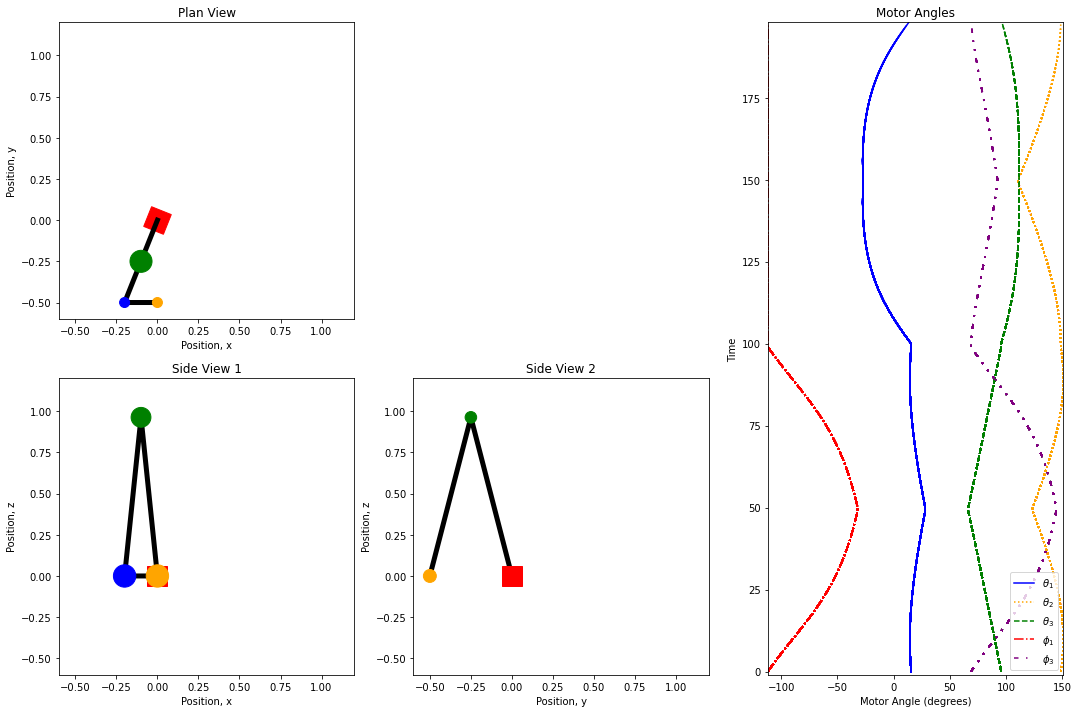

In [159]:

def circle():
    f = 200
    z = np.zeros(f) + 2
    i = np.linspace(0, np.pi*2, f)
    x = 0.7*np.cos(i) + 0.7
    y = 0.7*np.sin(i) + 0.7
    phi = theta = np.zeros(f)
    theta = np.zeros(f)+np.pi/5
    return x, y, z, phi, theta

def square():
    f = 200
    
    y = np.zeros(4*round(f/4)) - 0.5
    
    x = np.concatenate((np.linspace(0, 1, round(f/4)),
                        np.linspace(1, 1, round(f/4)),
                        np.linspace(1, 0, round(f/4)),
                        np.linspace(0, 0, round(f/4))), axis=0)
    
    z = np.concatenate((np.linspace(0, 0, round(f/4)),
                        np.linspace(0, 1, round(f/4)),
                        np.linspace(1, 1, round(f/4)),
                        np.linspace(1, 0, round(f/4))), axis=0)
    

def vaccine():
    f = 200
    
    y = np.zeros(4*round(f/4)) - 0.5
    
    x = np.concatenate((np.linspace(0, 1, round(f/4)),
                        np.linspace(1, 0, round(f/4)),
                        np.linspace(0, 0, round(f/4)),
                        np.linspace(0, 0, round(f/4))), axis=0)
    
    z = np.concatenate((np.linspace(0, 0, round(f/4)),
                        np.linspace(0, 0, round(f/4)),
                        np.linspace(0, 1, round(f/4)),
                        np.linspace(1, 0, round(f/4))), axis=0)
    
    phi = np.zeros(4*round(f/4))
    theta = np.zeros(4*round(f/4)) + np.pi/2
    return x, y, z, phi, theta

    


x, y, z, phi, theta = vaccine()





th1, th2, th3, phi1, phi3,_,_,_ = get_angles(x, y, z, phi, theta, r1=1, r2=1, r3=0.2)



x_points, y_points, z_points = arm_coords(th1, th2, th3, phi1, phi3, r1=1, r2=1, r3=0.2)

animate_5dof(x_points, y_points, z_points, th1, th2, th3, phi1, phi3)



